<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->
# DE-Sim tutorial

DE-Sim is an open-source, object-oriented, discrete-event simulation (OO DES) tool implemented in Python.
DE-Sim makes it easy to build and simulate discrete-event models.
This page introduces the basic concepts of discrete-event modeling and teaches you how to build and simulate discrete-event models with DE-Sim. 

## Installation
Use `pip` to install `de_sim`.

In [1]:
!pip install de_sim

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent

![gray_line](gray_horiz_line.svg)

## DE-Sim model of a one-dimensional random walk

<font size="4">Three steps: define an event message class; define a simulation object class; and build and run a simulation.</font>

### 1: Create an event message class by subclassing [`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage).

<font size="4">Each DE-Sim event contains an event message that provides data to the simulation object which executes the event.
The random walk model sends event messages that contain the value of a random step.</font>

In [2]:
import de_sim

class RandomStepMessage(de_sim.EventMessage):
    "An event message class that stores the value of a random walk step"
    step_value: float

![gray_line](gray_horiz_line.svg)

### 2: Subclass `SimulationObject` to define a simulation object class

<font size="4">
Simulation objects are like threads: a simulation's scheduler decides when to execute them, and their execution is suspended when they have no work to do.
But a DES scheduler schedules simulation objects to ensure that events occur in simulation time order. Precisely, the fundamental invariant of discrete-event simulation:
<br>
<br>
1. All events in a simulation are executed in non-decreasing time order.

By guaranteeing this behavior, the DE-Sim scheduler ensures that causality relationships between events are respected.

This invariant has two consequences:

1. All synchronization between simulation objects is controlled by the simulation times of events.
2. Each simulation object executes its events in non-decreasing time order.

The Python classes that generate and handle simulation events are simulation object classes, subclasses of `SimulationObject` which uses a custom class creation method that gives special meaning to certain methods and attributes.

Below, we define a simulation object class that models a random walk which randomly selects the time delay between steps, and illustrates all key features of `SimulationObject`.
</font>

In [3]:
import random

class RandomWalkSimulationObject(de_sim.SimulationObject):
    " A 1D random walk model, with random delays between steps "

    def __init__(self, name):
        super().__init__(name)

    def init_before_run(self):
        " Initialize before a simulation run; called by the simulator "
        self.position = 0
        self.history = {'times': [0],
                        'positions': [0]}
        self.schedule_next_step()

    def schedule_next_step(self):
        " Schedule the next event, which is a step "
        # A step moves -1 or +1 with equal probability
        step_value = random.choice([-1, +1])
        # The time between steps is 1 or 2, with equal probability
        delay = random.choice([1, 2])
        # Schedule an event `delay` in the future for this object
        # The event contains a `RandomStepMessage` with `step_value=step_value`
        self.send_event(delay, self, RandomStepMessage(step_value))

    def handle_step_event(self, event):
        " Handle a step event "
        # Update the position and history
        self.position += event.message.step_value
        self.history['times'].append(self.time)
        self.history['positions'].append(self.position)
        self.schedule_next_step()

    # `event_handlers` contains pairs that map each event message class
    # received by this simulation object to the method that handles
    # the event message class
    event_handlers = [(RandomStepMessage, handle_step_event)]

    # messages_sent registers all message types sent by this object
    messages_sent = [RandomStepMessage]

<font size="4">
DE-Sim simulation objects employ special methods and attributes:
<br>

* Special `SimulationObject` methods:
    1. **`init_before_run`** (optional): immediately before a simulation run, the simulator calls each simulation object’s `init_before_run` method. In this method simulation objects can send initial events and perform other initializations.
    2. **`send_event`**: `send_event(delay, receiving_object, event_message)` schedules an event to occur `delay` time units in the future at simulation object `receiving_object`. `event_message` must be an [`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage) instance. An event can be scheduled for any simulation object in a simulation.
The event will be executed at its scheduled simulation time by an event handler in the simulation object `receiving_object`.
The `event` parameter in the handler will be the scheduled event, which contains `event_message` in its `message` attribute.
    3. **event handlers**: Event handlers have the signature `event_handler(self, event)`, where `event` is a simulation event. A subclass of `SimulationObject` must define at least one event handler, as illustrated by `handle_step_event` above.
<br>
<br>
* Special `SimulationObject` attributes:
    1. **`event_handlers`**: a simulation object can receive arbitrarily many types of event messages, and implement arbitrarily many event handlers. The attribute `event_handlers` contains an iterator over pairs that map each event message class received to the event handler which handles the event message class.
    2. **`time`**: `time` is a read-only attribute that always equals the current simulation time.
</font>

![gray_line](gray_horiz_line.svg)

### 3: Execute a simulation by creating and initializing a [`Simulator`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.simulator.Simulator), and running the simulation.

<font size="4">
The `Simulator` class simulates models.
Its `add_object` method adds a simulation object to the simulator.
Each object in a simulation must have a unique `name`.
The `initialize` method, which calls each simulation object’s `init_before_run` method, must be called before a simulation starts.

At least one simulation object in a simulation must schedule an initial event--otherwise the simulation cannot start.
More generally, a simulation with no events to execute will terminate.

Finally, `run` simulates a model. It takes the maximum time of a simulation run. `run` also takes several optional configuration arguments.
</font>

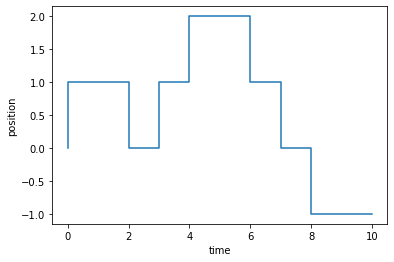

In [4]:
# Create a simulator
simulator = de_sim.Simulator()

# Create a random walk simulation object and add it to the simulation
random_walk_sim_obj = RandomWalkSimulationObject('rand_walk')
simulator.add_object(random_walk_sim_obj)

# Initialize the simulation
simulator.initialize()

# Run the simulation until time 10
max_time = 10
simulator.run(max_time)

# Plot the random walk
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=1.0)
ax.yaxis.set_major_locator(loc)
plt.step(random_walk_sim_obj.history['times'],
         random_walk_sim_obj.history['positions'],
         where='post')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

<font size="4">
This example runs a simulation for `max_time` time units, and plots the random walk’s trajectory.

This trajectory illustrates two key characteristics of discrete-event models. First, the state changes at discrete times.
Second, since the state does not change between instantaneous events, the trajectory of any state variable is a step function.
</font>

![gray_line](gray_horiz_line.svg)

## DE-Sim example with multiple object instances

<font size="4">
We show an DE-Sim implementation of the parallel hold (PHOLD) model, frequently used to benchmark parallel DES simulators.
<br>
<br>
We illustrate these DE-Sim features:

* Use multiple [`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage) types
* Run multiple instances of a simulation object type
* Simulation objects scheduling events for each other
</font>

In [5]:
""" Messages for the PHOLD benchmark for parallel discrete-event simulators """
import random

class MessageSentToSelf(de_sim.EventMessage):
    "A message that's sent to self"

class MessageSentToOtherObject(de_sim.EventMessage):
    "A message that's sent to another PHold simulation object"

class InitMsg(de_sim.EventMessage):
    "An initialization message"

MESSAGE_TYPES = [MessageSentToSelf, MessageSentToOtherObject, InitMsg]

In [6]:
class PholdSimulationObject(de_sim.SimulationObject):
    """ Run a PHOLD simulation """
    def __init__(self, name, args):
        self.args = args
        super().__init__(name)

    def init_before_run(self):
        self.send_event(random.expovariate(1.0), self, InitMsg())

    @staticmethod
    def record_event_header():
        print('\t'.join(('Sender', 'Send', "Receivr",
                         'Event', 'Message type')))
        print('\t'.join(('', 'time', '', 'time', '')))
        
    def record_event(self, event):
        record_format = '{}\t{:.2f}\t{}\t{:.2f}\t{}'
        print(record_format.format(event.sending_object.name,
                                   event.creation_time,
                                   event.receiving_object.name,
                                   self.time,
                                   type(event.message).__name__))

    def handle_simulation_event(self, event):
        """ Handle a simulation event """
        # Record this event
        self.record_event(event)
        # Schedule an event
        if random.random() < self.args.frac_self_events or \
            self.args.num_phold_objects == 1:
            receiver = self
        else:
            # Send the event to another randomly selected object
            obj_index = random.randrange(self.args.num_phold_objects - 1)
            if int(self.name) <= obj_index:
                obj_index += 1
            receiver = self.simulator.simulation_objects[str(obj_index)]

        if receiver == self:
            message_type = MessageSentToSelf
        else:
            message_type = MessageSentToOtherObject
        self.send_event(random.expovariate(1.0), receiver, message_type())

    event_handlers = [(sim_msg_type, 'handle_simulation_event') \
                      for sim_msg_type in MESSAGE_TYPES]

    messages_sent = MESSAGE_TYPES

<font size="4">
The PHOLD model runs multiple instances of `PholdSimulationObject`.

`create_and_run` creates the objects and adds them to the simulator.

Each `PholdSimulationObject` object is initialized with `args`, an object that defines two attributes used by all objects:

* `args.num_phold_objects`: the number of PHOLD objects running
* `args.frac_self_events`: the fraction of events sent to self

At time 0, each PHOLD object schedules an `InitMsg` event for itself that occurs after a random exponential time delay with mean = 1.0.

The `handle_simulation_event` method handles all events.
Each event schedules one more event.
A random value in [0, 1) is used to decide whether to schedule the event for itself (with probability `args.frac_self_events`) or for another PHOLD object.

If the event is scheduled for another PHOLD object, this gets a reference to the object: 

    receiver = self.simulator.simulation_objects[str(obj_index)]

The attribute `self.simulator` always references the running simulator, and `self.simulator.simulation_objects` is a dictionary that maps simulation object names to simulation objects.
</font>

<font size="4">
Each event is printed by `record_event`.
It accesses the DE-Sim `Event` object that is passed to all event handlers.
`de_sim.event.Event` contains five useful fields:

* `sending_object`: the object that created and sent the event
* `creation_time`: the simulation time when the event was created (a.k.a. its *send time*)
* `receiving_object`: the object that received the event
* `event_time`: the simulation time when the event must execute (a.k.a. its *receive time*)
* `message`: the [`EventMessage`](https://docs.karrlab.org/de_sim/master/source/de_sim.html#de_sim.event_message.EventMessage) carried by the event

However, rather than use the event's `event_time`, `record_event` uses `self.time` to report the simulation time when the event is being executed, as they are always equal.
</font>
![gray_line](gray_horiz_line.svg)

### Execute the simulation
<font size="4">
Run a short simulation, and print all events:
</font>



In [7]:
def create_and_run(args):

    # create a simulator
    simulator = de_sim.Simulator()

    # create simulation objects, and send each one an initial event message to self
    for obj_id in range(args.num_phold_objects):
        phold_obj = PholdSimulationObject(str(obj_id), args)
        simulator.add_object(phold_obj)

    # run the simulation
    simulator.initialize()
    PholdSimulationObject.record_event_header()
    event_num = simulator.simulate(args.max_time).num_events
    print("Executed {} events.\n".format(event_num))

In [8]:
from argparse import Namespace
args = Namespace(max_time=2,
                 frac_self_events=0.3,
                 num_phold_objects=6)
create_and_run(args)

Sender	Send	Receivr	Event	Message type
	time		time	
5	0.00	5	0.19	InitMsg
3	0.00	3	0.37	InitMsg
5	0.19	3	0.38	MessageSentToOtherObject
1	0.00	1	0.54	InitMsg
3	0.37	2	0.59	MessageSentToOtherObject
2	0.00	2	0.59	InitMsg
2	0.59	2	0.72	MessageSentToSelf
2	0.59	3	1.11	MessageSentToOtherObject
3	0.38	5	1.16	MessageSentToOtherObject
3	1.11	3	1.28	MessageSentToSelf
0	0.00	0	1.48	InitMsg
2	0.72	0	1.55	MessageSentToOtherObject
0	1.48	3	1.80	MessageSentToOtherObject
Executed 13 events.

